<a href="https://colab.research.google.com/github/RachelNderitu/RachelNderitu/blob/main/Fine_Tuned_CATS_VS_DOGS%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DOWNLOAD IMPORTANT LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomZoom


OBTAIN DATA

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')


68606236/68606236 [==============================] - 1s 0us/step


BEGIN TRAINING: Defining variables & loading datasets

In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Define train and validation directories
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Load train and validation datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


First Nine Images & their Labels

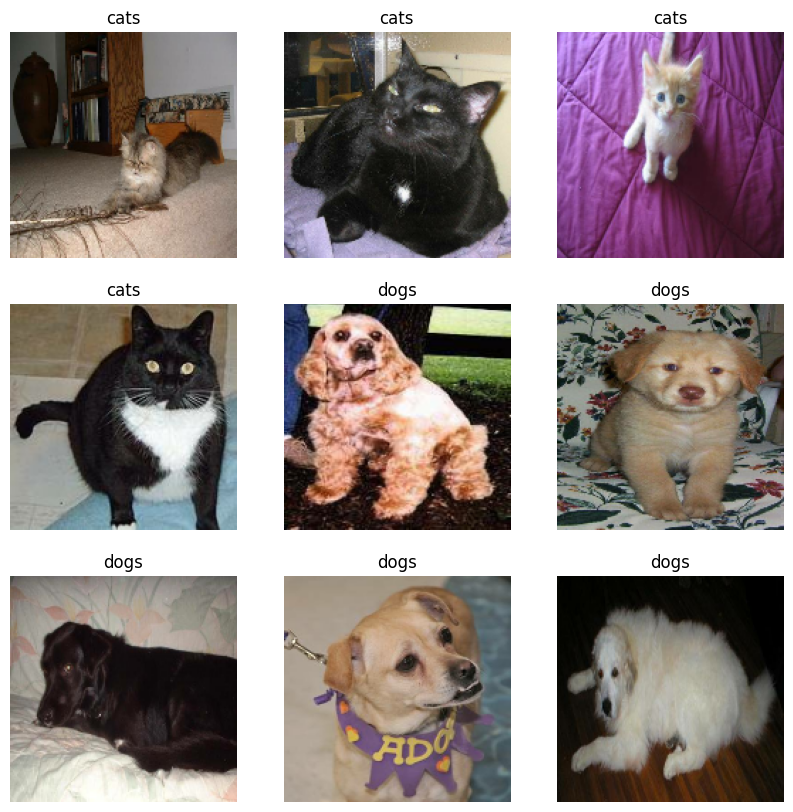

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

CONFIGURE DATASET FOR PERFORMANCE

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

DATA AUGMENTATION

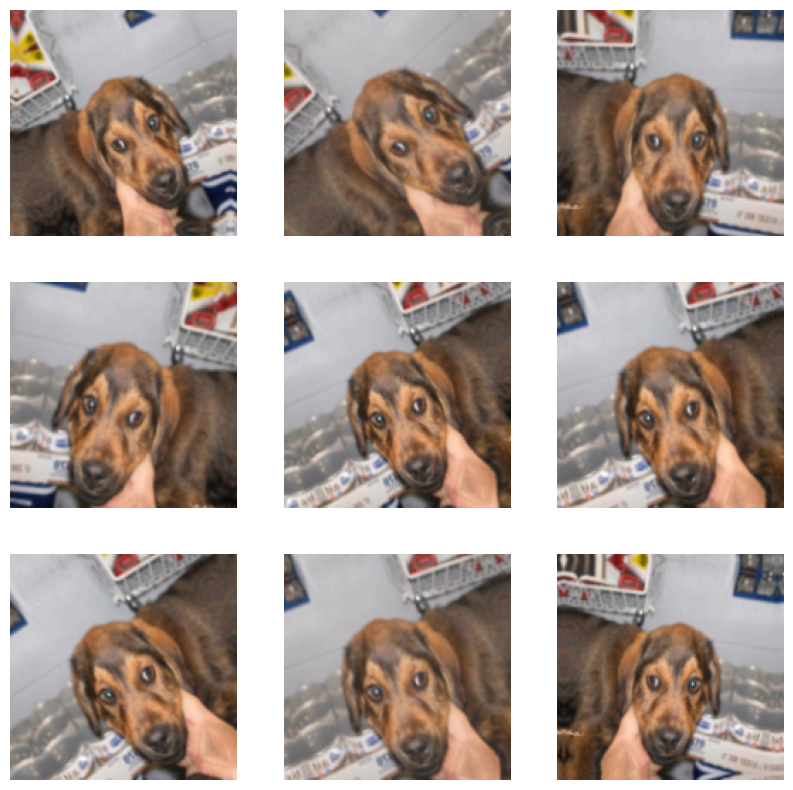

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  RandomContrast(0.1),
  RandomZoom(0.1),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

RESCALE PIXEL VALUES

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

CREATE BASE MODEL

In [8]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

9406464/9406464 [==============================] - 0s 0us/step
(32, 5, 5, 1280)


FEATURE EXTRACTION: Freeze Base

In [9]:
base_model.trainable = False

Build the Model

In [10]:
#Classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

#Conversion to a single prediction per image
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

#Create the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

(32, 1280)
(32, 1)


COMPILE THE MODEL

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

TRAIN THE MODEL

In [12]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

32/32 [==============================] - 21s 604ms/step - loss: 0.6476 - accuracy: 0.6240
initial loss: 0.65
initial accuracy: 0.62


In [13]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 72s 1s/step - loss: 0.6042 - accuracy: 0.6915 - val_loss: 0.4576 - val_accuracy: 0.7960
Epoch 2/10
63/63 [==============================] - 70s 1s/step - loss: 0.4694 - accuracy: 0.7955 - val_loss: 0.3490 - val_accuracy: 0.8880
Epoch 3/10
63/63 [==============================] - 68s 1s/step - loss: 0.3986 - accuracy: 0.8280 - val_loss: 0.2804 - val_accuracy: 0.9160
Epoch 4/10
63/63 [==============================] - 65s 1s/step - loss: 0.3403 - accuracy: 0.8590 - val_loss: 0.2339 - val_accuracy: 0.9360
Epoch 5/10
63/63 [==============================] - 70s 1s/step - loss: 0.3124 - accuracy: 0.8780 - val_loss: 0.2035 - val_accuracy: 0.9420
Epoch 6/10
63/63 [==============================] - 69s 1s/step - loss: 0.2822 - accuracy: 0.8865 - val_loss: 0.1811 - val_accuracy: 0.9540
Epoch 7/10
63/63 [==============================] - 69s 1s/step - loss: 0.2542 - accuracy: 0.9020 - val_loss: 0.1647 - val_accuracy: 0.9580
Epoch 8/10
63/63 [==

FINE-TUNING:
Layers & Weights

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0
weights: 4
trainable_weights: 2
non_trainable_weights: 2
weights: 2
trainable_weights: 0
non_trainable_weights: 2


TRAIN NEW MODEL

In [15]:

# Train the model
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# Fine-tune the model
base_model.trainable = True
fine_tune_at = 140  # Fine-tuning from this layer onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 66s 1s/step - loss: 0.2251 - accuracy: 0.9180 - val_loss: 0.1243 - val_accuracy: 0.9700
Epoch 2/10
63/63 [==============================] - 67s 1s/step - loss: 0.2100 - accuracy: 0.9190 - val_loss: 0.1167 - val_accuracy: 0.9710
Epoch 3/10
63/63 [==============================] - 67s 1s/step - loss: 0.2051 - accuracy: 0.9165 - val_loss: 0.1118 - val_accuracy: 0.9710
Epoch 4/10
63/63 [==============================] - 68s 1s/step - loss: 0.1960 - accuracy: 0.9255 - val_loss: 0.1069 - val_accuracy: 0.9710
Epoch 5/10
63/63 [==============================] - 68s 1s/step - loss: 0.1867 - accuracy: 0.9260 - val_loss: 0.1018 - val_accuracy: 0.9720
Epoch 6/10
63/63 [==============================] - 68s 1s/step - loss: 0.1880 - accuracy: 0.9225 - val_loss: 0.0980 - val_accuracy: 0.9720
Epoch 7/10
63/63 [==============================] - 69s 1s/step - loss: 0.1806 - accuracy: 0.9275 - val_loss: 0.0944 - val_accuracy: 0.9750
Epoch 8/10
63/63 [==

EVALUATE FINE-TUNED MODEL

In [16]:
# Evaluate the fine-tuned model
loss, accuracy = model.evaluate(validation_dataset)
print("Fine-tuned model validation loss:", loss)
print("Fine-tuned model validation accuracy:", accuracy)

# Calculate precision, recall, and F1-score
predictions = model.predict(validation_dataset)
binary_predictions = (predictions > 0.5).astype(int)
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
f1_score = 2 * ((precision * recall) / (precision + recall))

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)

32/32 [==============================] - 20s 604ms/step - loss: 0.0413 - accuracy: 0.9850
Fine-tuned model validation loss: 0.04134850576519966
Fine-tuned model validation accuracy: 0.9850000143051147
32/32 [==============================] - 21s 595ms/step
Precision: 0.5150300601202404
Recall: 0.514
F1-score: 0.5145145145145146


DISPLAY IMAGES

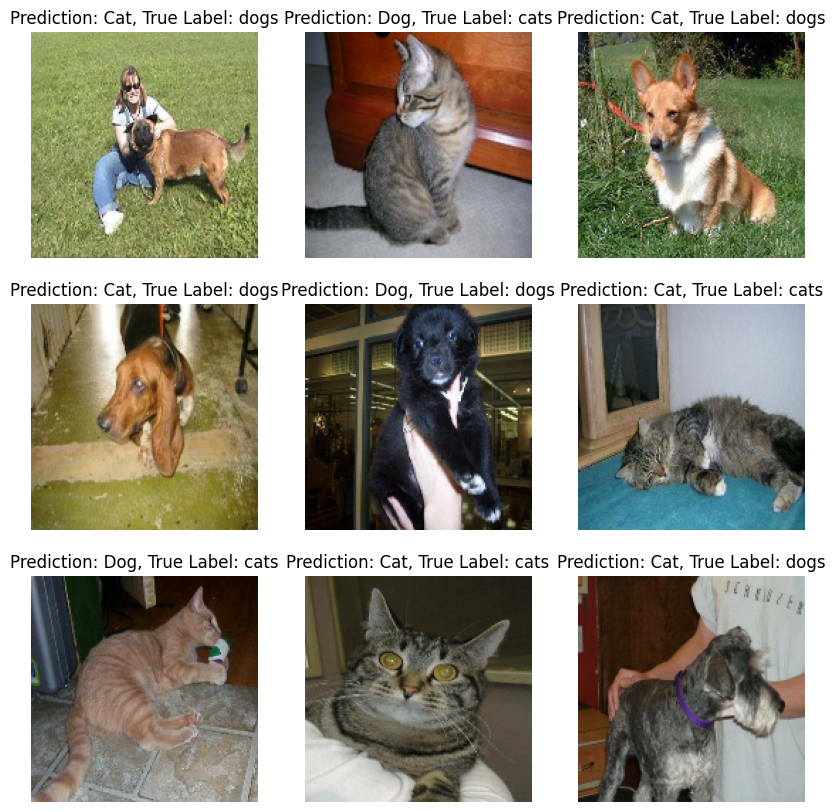

In [17]:
# Display images and their predictions
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Prediction: {'Dog' if binary_predictions[i] == 1 else 'Cat'}, True Label: {class_names[labels[i]]}")
        plt.axis("off")
plt.show()

Model Evaluation and Fine-tuning Report

The notebook trains a binary image classifier to distinguish between cats and dogs. It uses a pre-trained ResNet50 model as a base, initially freezing its layers and training only a custom classification head.

Evaluation Metrics

The model's performance is evaluated using the following metrics:

Accuracy: Overall correctness of predictions.
Precision: Proportion of correctly predicted positives out of all predicted positives.
Recall: Proportion of correctly predicted positives out of all actual positives.
F1-score: Harmonic mean of precision and recall, balancing both.
These metrics are calculated on the validation dataset to assess how well the model generalizes to unseen data.

Fine-tuning

After initial training, the base ResNet50 model is unfrozen from a certain layer onwards (fine_tune_at), and the entire model is further trained with a reduced learning rate. This fine-tuning process allows the model to adapt more specifically to the cat vs. dog classification task.

Comparison and Discussion

To fully address the comparison between the pre-trained and fine-tuned models, you would need to record and present the evaluation metrics for both stages. The provided code only shows evaluation for the fine-tuned model.

However, generally, fine-tuning is expected to improve performance on the specific task compared to using the pre-trained model directly. The extent of improvement depends on factors like the similarity of the pre-training dataset to the target task, the amount of fine-tuning, and the choice of hyperparameters.

Challenges during fine-tuning might include overfitting if the dataset is small, or difficulty in finding the optimal balance between unfreezing layers and preventing catastrophic forgetting of pre-trained knowledge.
